## EM-APEX floats: Conversion of relative velocities to absolute velocities

In [1]:
import os
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import gsw
import matplotlib.dates as mdates
import warnings

%matplotlib inline

plt.rcParams['font.size'] = '14'

warnings.filterwarnings("ignore", category=RuntimeWarning)

In [2]:
import imp
import src.importData as imports
import src.calc as calc
import src.plots as plots
import src.velocities as vel
import src.concat as ct
import src.interpolation as interp
import src.settings as settings
import src.stats as stats

In [ ]:
my_path = os.path.join(os.sep, 'Users', 'mijakes', 'checkouts', 'phd','figures', 'chapter1_manuscript', 'revision_figures')

In [3]:
# import float data with relative velocities and ctd time measurements
floatids = [8489, 8492, 8493]
floatdir = os.path.join(os.sep, 'Users', 'mijakes', 'checkouts', 'phd', 'data', 'floats', 'extra_vars')

ema = {}
u_rel = {}
v_rel = {}
imp.reload(vel)
for floatid in floatids:
    input_file = os.path.join(floatdir, 'macquarie_ema-%s_qc.nc' %floatid)
    ema[floatid] = xr.open_dataset(input_file)
    
    u_rel[floatid] = vel.erroneous_rel_vels(ema[floatid].u_rel, floatid)
    v_rel[floatid] = vel.erroneous_rel_vels(ema[floatid].v_rel, floatid)


In [ ]:
# satellite altimetry dataset 
datadir = os.path.join(os.sep, 'Users', 'mijakes', 'checkouts', 'phd', 'data')
alt_cmems = imports.importNetCDF(datadir, 'CMEMS.nc', datatype ='altimetry')

In [4]:
floatid = 8492
float_num = ema[floatid]
rs = calc.findRSperiod(float_num)

Text(0, 0.5, 'pressure (dbar)')

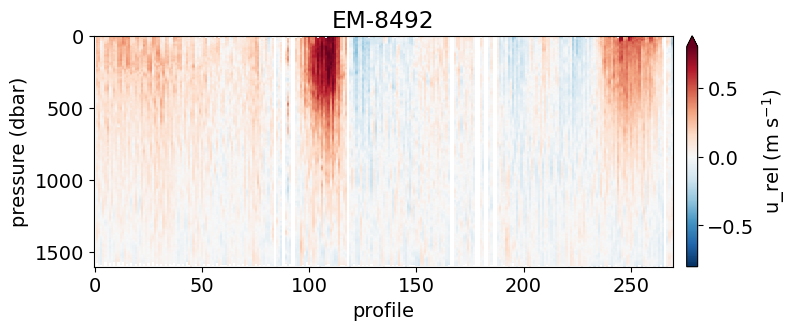

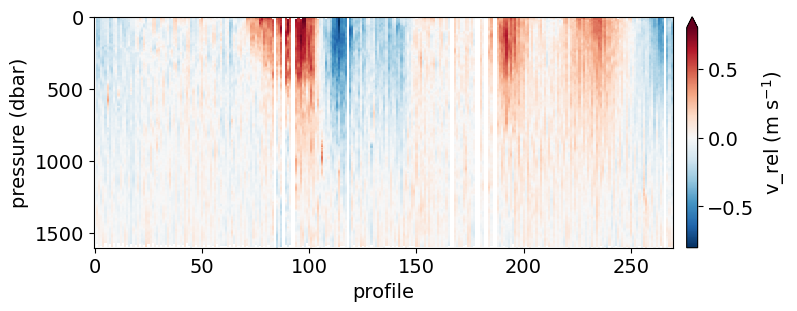

In [5]:
fig, ax = plt.subplots(figsize = (9, 3))
u_rel[floatid][rs].plot(x = 'profile', vmin = -0.8, vmax = 0.8, cmap = 'RdBu_r', 
                        cbar_kwargs = dict(label = 'u_rel (m s$^{-1}$)', pad = 0.02))
ax.invert_yaxis()
plt.title(f'EM-{floatid}')
plt.ylabel('pressure (dbar)')

# settings.save_figure(fig, my_path, 'u_rel.png', dpi = 600, pad = 0.2)

fig, ax = plt.subplots(figsize = (9, 3))
v_rel[floatid][rs].plot(x = 'profile', vmin = -0.8, vmax = 0.8, cmap = 'RdBu_r',
                        cbar_kwargs = dict(label = 'v_rel (m s$^{-1}$)', pad = 0.02))
ax.invert_yaxis()
plt.ylabel('pressure (dbar)')

# settings.save_figure(fig, my_path, 'v_rel.png', dpi = 600, pad = 0.2)

### Is there an ascent/descent bias?

In [6]:
shp = u_rel[floatid][rs].shape
diff_u = np.zeros(shp)#*np.nan
diff_v = np.zeros(shp)#*np.nan

for i in range(0, len(u_rel[floatid][rs]), 2):
    diff_u[i] = (u_rel[floatid][rs][i] - u_rel[floatid][rs][i+1])
#     diff_u[i+1] = (u_rel[floatid][rs][i] - u_rel[floatid][rs][i+1])
    
    diff_v[i] = (v_rel[floatid][rs][i] - v_rel[floatid][rs][i+1])
#     diff_v[i+1] = (v_rel[floatid][rs][i] - v_rel[floatid][rs][i+1])

diff_u = xr.DataArray(diff_u, dims = ['profile', 'pressure'], coords = u_rel[floatid][rs].coords)   
diff_v = xr.DataArray(diff_v, dims = ['profile', 'pressure'], coords = v_rel[floatid][rs].coords)   

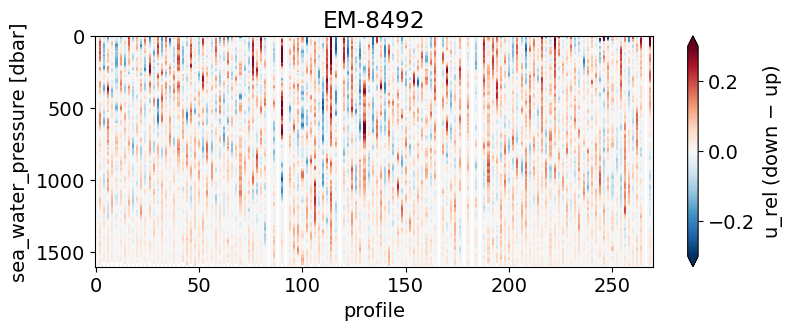

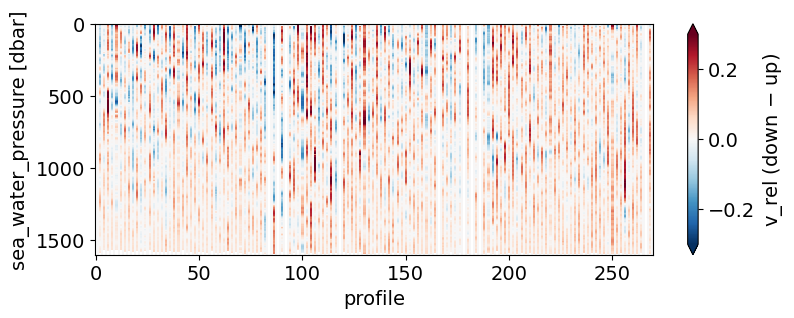

In [7]:
fig, ax = plt.subplots(figsize = (9, 3))
diff_u.plot(x = 'profile', vmin = -0.3, vmax = 0.3, cmap = 'RdBu_r', cbar_kwargs = dict(label = r'u_rel (down $-$ up)'))
ax.invert_yaxis()
plt.title(f'EM-{floatid}')

fig, ax = plt.subplots(figsize = (9, 3))
diff_v.plot(x = 'profile', vmin = -0.3, vmax = 0.3, cmap = 'RdBu_r', cbar_kwargs = dict(label = r'v_rel (down $-$ up)'))
ax.invert_yaxis()

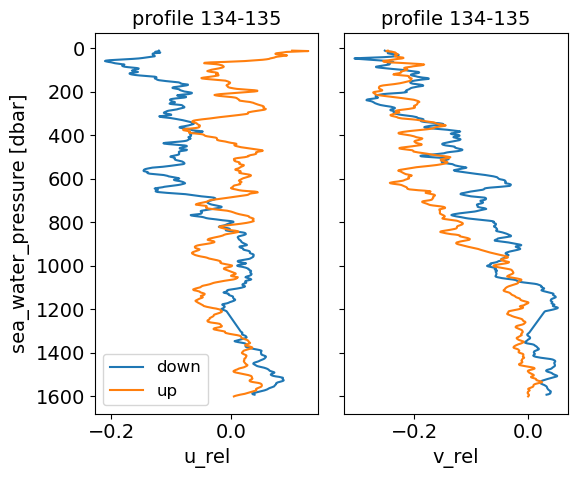

In [8]:
prof1 = 134
prof2 = prof1+1

fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize = (6,5))
u_rel[floatid][prof1].plot(ax = ax1, y = 'pressure')
u_rel[floatid][prof2].plot(ax = ax1,y = 'pressure')
ax1.legend(['down', 'up'], fontsize = 12)
ax1.set_xlabel('u_rel')

v_rel[floatid][prof1].plot(ax = ax2, y = 'pressure')
v_rel[floatid][prof2].plot(ax = ax2, y = 'pressure')
ax1.invert_yaxis()
ax1.set_title(f'profile {prof1}-{prof2}', fontsize = 14)
ax2.set_title(f'profile {prof1}-{prof2}', fontsize = 14)
ax2.set_xlabel('v_rel')
ax2.set_ylabel('')

plt.tight_layout()

### Create absolute velocity dataset

In [9]:
# imp.reload(vel)
# abs_vel = vel.createAbsVelDataset(float_num, floatid, u_rel[floatid], v_rel[floatid], by_dist = True, save_file = True)

### Import saved datasets

In [10]:
datadir = os.path.join(os.sep, 'Users', 'mijakes', 'checkouts', 'phd', 'data', 'floats', 'absolute_velocity')

abs_v_prof = {}
abs_v_dist = {}
for floatid in floatids:
    #absolute velocities
    file = os.path.join(datadir, 'by_profile', 'abs_vel_%s_extra_qc.nc' %floatid)
    abs_v_prof[floatid] = xr.open_dataset(file)
    
    file = os.path.join(datadir, 'by_distance', 'abs_vel_%s_extra_qc.nc' %floatid)
    abs_v_dist[floatid] = xr.open_dataset(file)

#### Check velocities

In [11]:
floatid = 8492
float_num = ema[floatid]
rs = calc.findRSperiod(float_num)

In [12]:
u_abs = vel.setAbsVelToNan(floatid, abs_v_prof[floatid].u_abs)
v_abs = vel.setAbsVelToNan(floatid, abs_v_prof[floatid].v_abs)

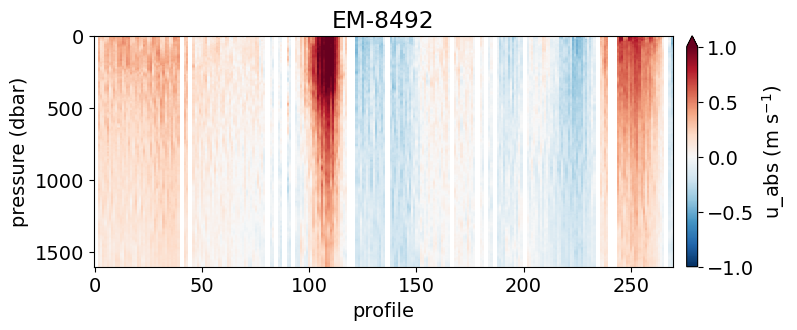

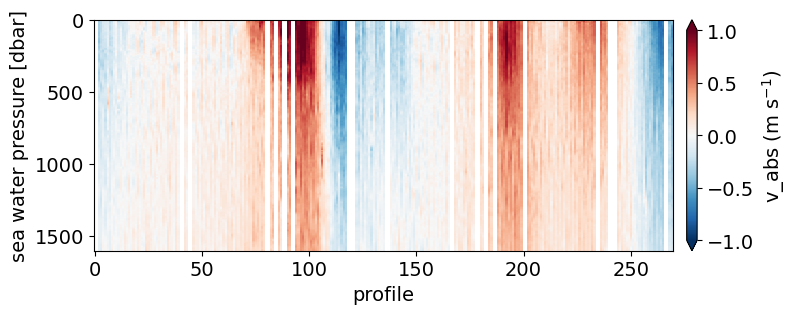

In [13]:
# check 
fig, ax = plt.subplots(figsize = (9, 3))
u_abs.plot(x = 'profile', vmin = -1, vmax = 1, cmap = 'RdBu_r', 
           cbar_kwargs = dict(label = 'u_abs (m s$^{-1}$)', pad = 0.02))
ax.invert_yaxis()
plt.title(f'EM-{floatid}')
plt.ylabel('pressure (dbar)')

fig, ax = plt.subplots(figsize = (9, 3))
v_abs.plot(x = 'profile', vmin = -1, vmax = 1, cmap = 'RdBu_r', 
           cbar_kwargs = dict(label = 'v_abs (m s$^{-1}$)', pad = 0.02))
ax.invert_yaxis()

Text(0, 0.5, 'pressure (dbar)')

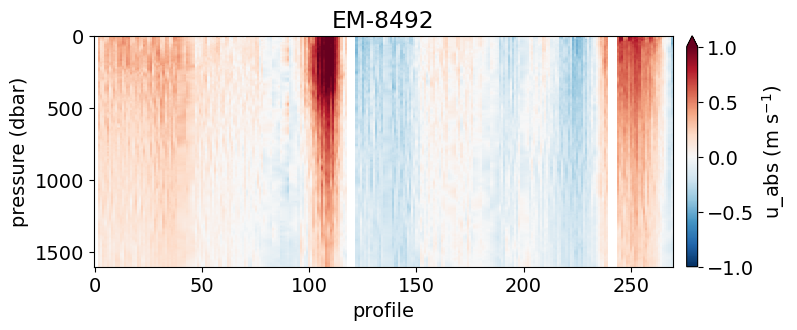

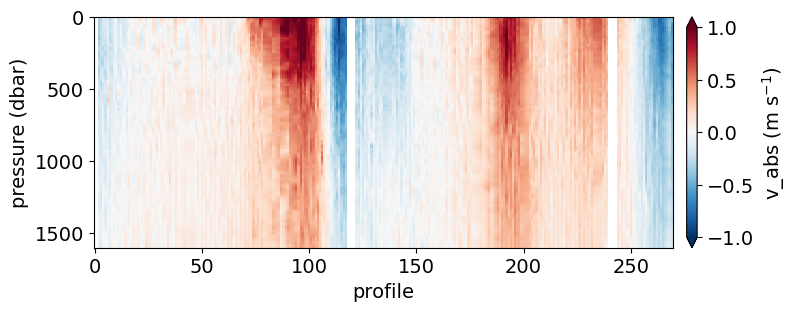

In [14]:
# check 
fig, ax = plt.subplots(figsize = (9, 3))
u_abs.interpolate_na('profile', method = 'linear', max_gap = 3).plot(x = 'profile', vmin = -1, vmax = 1, cmap = 'RdBu_r', 
                                                         cbar_kwargs = dict(label = 'u_abs (m s$^{-1}$)', pad = 0.02))
ax.invert_yaxis()
plt.title(f'EM-{floatid}')
plt.ylabel('pressure (dbar)')

# settings.save_figure(fig, my_path, 'u_abs.png', dpi = 600, pad = 0.2)

fig, ax = plt.subplots(figsize = (9, 3))
v_abs.interpolate_na('profile', method = 'linear', max_gap = 3).plot(x = 'profile', vmin = -1, vmax = 1, cmap = 'RdBu_r', 
                                                         cbar_kwargs = dict(label = 'v_abs (m s$^{-1}$)', pad = 0.02))
ax.invert_yaxis()
plt.ylabel('pressure (dbar)')

# settings.save_figure(fig, my_path, 'v_abs.png', dpi = 600, pad = 0.2)

### Is there an ascent/descent bias?

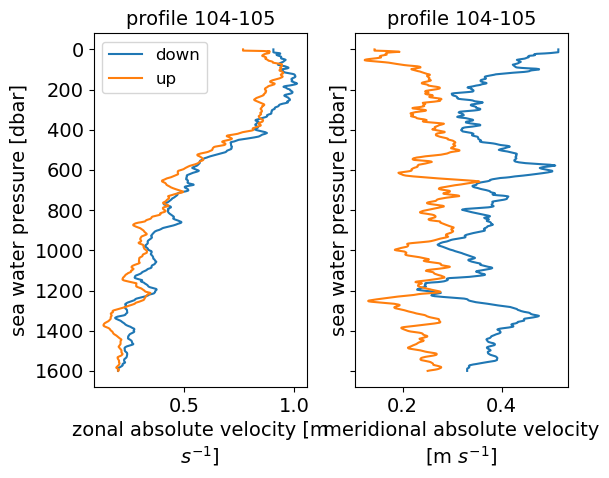

In [15]:
prof1 = 104
prof2 = prof1+1

fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize = (6,5))
u_abs[prof1].plot(ax = ax1, y = 'pressure')
u_abs[prof2].plot(ax = ax1,y = 'pressure')
ax1.legend(['down', 'up'], fontsize = 12)

v_abs[prof1].plot(ax = ax2, y = 'pressure')
v_abs[prof2].plot(ax = ax2, y = 'pressure')
ax1.invert_yaxis()
ax1.set_title(f'profile {prof1}-{prof2}', fontsize = 14)
ax2.set_title(f'profile {prof1}-{prof2}', fontsize = 14)

plt.tight_layout()

### Plot subsurface float path according to relative velocities and absolute velocities (with offset added) 

u offset: [0.12065787], v offset: [0.04112185]


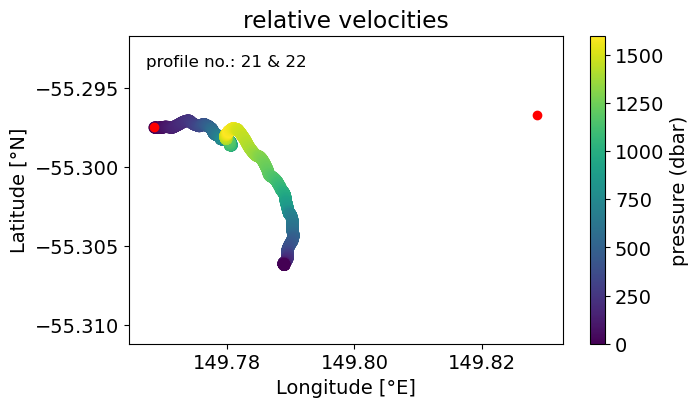

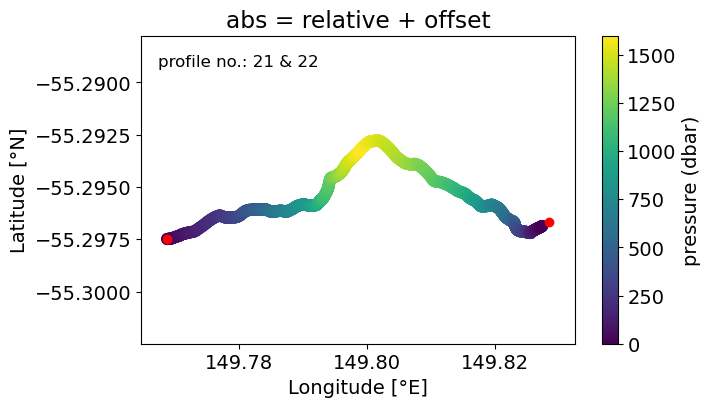

In [16]:
prof = 20 #12
imp.reload(vel)
fig = vel.plotSubsurfaceTrajectory(float_num, floatid, u_rel[floatid], v_rel[floatid], prof, abs_vels = False)
fig2 = vel.plotSubsurfaceTrajectory(float_num, floatid, u_rel[floatid], v_rel[floatid], prof, abs_vels = True, print_offset = False)

In [17]:
# settings.save_figure(fig, my_path, 'rel_subsurface.png', dpi = 600, pad = 0.2)
# settings.save_figure(fig2, my_path, 'abs_subsurface.png', dpi = 600, pad = 0.2)

# settings.save_figure(fig, my_path, 'err_rel_subsurface.png', dpi = 600, pad = 0.2)
# settings.save_figure(fig2, my_path, 'err_abs_subsurface.png', dpi = 600, pad = 0.2)

Text(0, 0.5, 'pressure (dbar)')

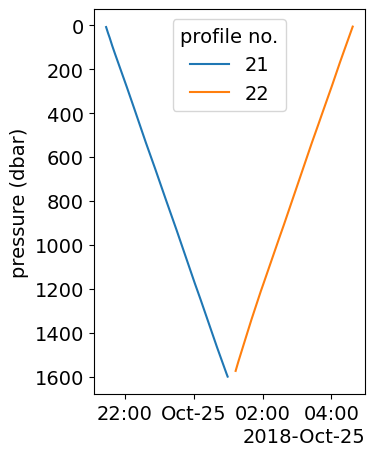

In [18]:
fig, ax = plt.subplots(figsize = (3.5,5))
plt.plot(float_num.ctd_t[prof], float_num.pressure)
plt.plot(float_num.ctd_t[prof+1], float_num.pressure)

locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)

ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

ax.invert_yaxis()
ax.legend([f'{prof+1}', f'{prof+1+1}'], title = 'profile no.', loc = 'upper center')
ax.set_ylabel('pressure (dbar)')

# settings.save_figure(fig, my_path, 'err_prof_137_138.png', dpi = 600, pad = 0.2)
# settings.save_figure(fig, my_path, 'prof_13_14.png', dpi = 600, pad = 0.2)

In [19]:
def find_nans(float_num):
    '''We fill missing velocity measurements at the surface and the bottom of the profile with nearest value 
    from that profile, assuming constant velocity. 
    This function returns the number of measurements filled at the surface and the bottom of each profile.'''
    
    warnings.filterwarnings("ignore")

    rs = calc.findRSperiod(float_num)
    
    surface = []
    bottom = []
    len_surf = []
    len_bottom = []
    for i in range(0, len(float_num.u_rel[rs])):
        nan_index = np.where(np.isnan(float_num.u_rel[i]))[0]
        
        if len(nan_index) < 20:
            ind_surf = np.where(nan_index < 20)[0]
            ind_bottom = np.where(nan_index > 700)[0]
            
            surface.append(ind_surf)
            bottom.append(ind_bottom)
            
            len_surf.append(len(ind_surf))
            len_bottom.append(len(ind_bottom))
            
    surface = np.asarray(surface)
    bottom = np.asarray(bottom)
    
    len_surf = np.asarray(len_surf)
    len_bottom = np.asarray(len_bottom)
    
    return surface, bottom, len_surf, len_bottom

In [45]:
for floatid in floatids:
    float_num = ema[floatid]
    rs = calc.findRSperiod(float_num)
    n_profiles = len(float_num.profile[rs])
    
    n_non_empty_profiles = len(find_nans(ema[floatid])[0])
    
    surface = len(np.where(find_nans(float_num)[2] <= 6)[0])
    bottom = len(np.where(find_nans(float_num)[3] <= 6)[0])
    
    print(f'EM-{floatid}')
    print(f'surface: {surface}')
    print(f'bottom: {bottom}')
    print(f'no. profiles: {n_profiles}')
    print(f'no. non empty profiles: {n_non_empty_profiles}')

EM-8489
surface: 235
bottom: 181
no. profiles: 268
no. non empty profiles: 249
EM-8492
surface: 233
bottom: 211
no. profiles: 270
no. non empty profiles: 249
EM-8493
surface: 113
bottom: 118
no. profiles: 264
no. non empty profiles: 118


In [46]:
# percentage of float profiles with <= 6 missing velocity measurements at the surface (excluding empty profiles)
(235 + 233 + 113) / (249 + 249 + 118) * 100

94.31818181818183

In [47]:
# percentage of float profiles with <= 6 missing velocity measurements at the bottom (excluding empty profiles)
(181 + 211 + 118) / (249 + 249 + 118) * 100

82.79220779220779

### Rage of offset values (histogram)

In [27]:
u_offset, v_offset = {}, {}
for floatid in floatids:
    rs = calc.findRSperiod(ema[floatid])
    u, v = vel.setAbsVelToNan(floatid, u_rel[floatid][rs]), vel.setAbsVelToNan(floatid, v_rel[floatid][rs])
    u_off, v_off = [], []
    for prof in range(0, len(u[rs])-2, 2):
        if np.isnan(u[prof]).all():
            u_off.append(np.nan)
            v_off.append(np.nan)
        else:
            du, dv = vel.calcVelOffset(ema[floatid], floatid, u, v, prof)
            u_off.append(float(du))
            v_off.append(float(dv))
            
    u_offset[floatid] = np.array(u_off)
    v_offset[floatid] = np.array(v_off)

In [16]:
np.arange(-0.42, 0.44,0.04)

array([-0.22, -0.18, -0.14, -0.1 , -0.06, -0.02,  0.02,  0.06,  0.1 ,
        0.14,  0.18,  0.22,  0.26,  0.3 ,  0.34,  0.38,  0.42])

Text(0, 0.5, 'no. profiles')

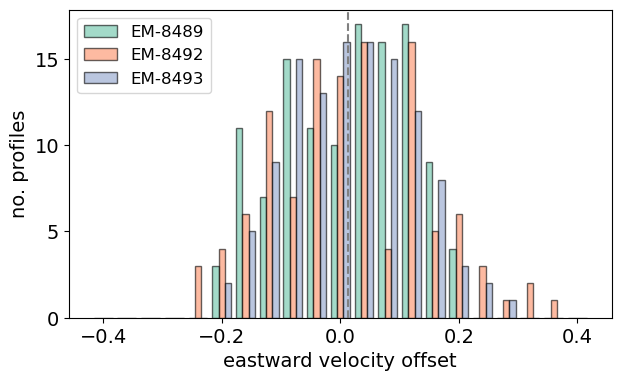

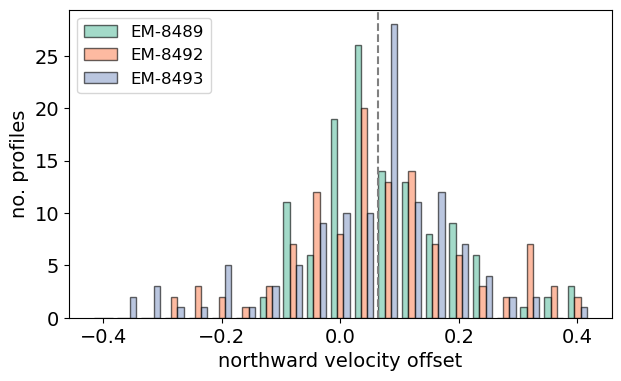

In [48]:
bins = np.arange(-0.42, 0.44,0.04)
cols = ['#66c2a5', '#fc8d62', '#8da0cb']

fig, ax = plt.subplots(figsize = (7,4))
n, bins, patches = plt.hist(x=[u_offset[8489], u_offset[8492], u_offset[8493]], bins=bins, edgecolor='black', color = cols,
                            alpha = 0.6, stacked = False)

plt.legend(["EM-8489","EM-8492","EM-8493"], fontsize = 12, loc = 'upper left')
mean_u_off = np.nanmean(np.concatenate([u_offset[8489], u_offset[8492], u_offset[8493]]))
plt.axvline(x = mean_u_off, linestyle = '--', c = 'grey')

ax.set_xlabel('eastward velocity offset')
ax.set_ylabel('no. profiles')



fig, ax = plt.subplots(figsize = (7,4))
n, bins, patches = plt.hist(x=[v_offset[8489], v_offset[8492], v_offset[8493]], bins=bins, edgecolor='black', color = cols,
                            alpha = 0.6, stacked = False)

plt.legend(["EM-8489","EM-8492","EM-8493"], fontsize = 12, loc = 'upper left')
mean_v_off = np.nanmean(np.concatenate([v_offset[8489], v_offset[8492], v_offset[8493]]))
plt.axvline(x = mean_v_off, linestyle = '--', c = 'grey')

ax.set_xlabel('northward velocity offset')
ax.set_ylabel('no. profiles')

Text(0, 0.5, 'no. profiles')

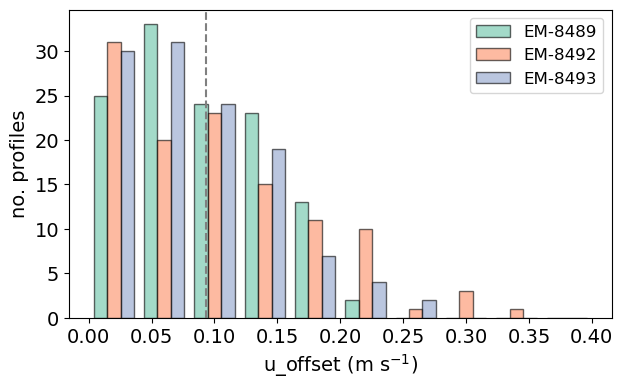

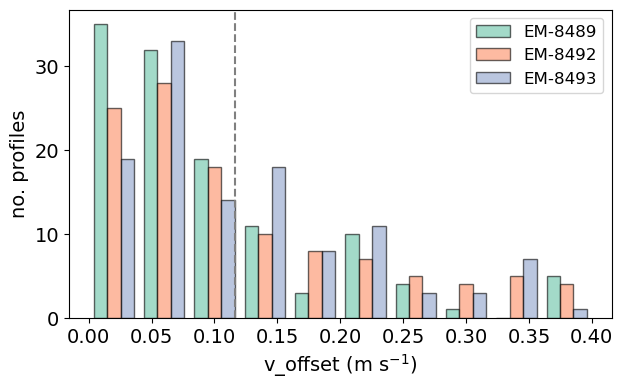

In [49]:
bins = np.arange(0, 0.44,0.04)
cols = ['#66c2a5', '#fc8d62', '#8da0cb']

fig, ax = plt.subplots(figsize = (7,4))
n, bins, patches = plt.hist(x=[abs(u_offset[8489]), abs(u_offset[8492]), abs(u_offset[8493])], bins=bins, edgecolor='black', color = cols,
                            alpha = 0.6, stacked = False)

plt.legend(["EM-8489","EM-8492","EM-8493"], fontsize = 12, loc = 'upper right')
mean_u_off = np.nanmean(abs(np.concatenate([u_offset[8489], u_offset[8492], u_offset[8493]])))
plt.axvline(x = mean_u_off, linestyle = '--', c = 'grey')

ax.set_xlabel('u_offset (m s$^{-1}$)')
ax.set_ylabel('no. profiles')



fig, ax = plt.subplots(figsize = (7,4))
n, bins, patches = plt.hist(x=[abs(v_offset[8489]), abs(v_offset[8492]), abs(v_offset[8493])], bins=bins, edgecolor='black', color = cols,
                            alpha = 0.6, stacked = False)

plt.legend(["EM-8489","EM-8492","EM-8493"], fontsize = 12, loc = 'upper right')
mean_v_off = np.nanmean(abs(np.concatenate([v_offset[8489], v_offset[8492], v_offset[8493]])))
plt.axvline(x = mean_v_off, linestyle = '--', c = 'grey')

ax.set_xlabel('v_offset (m s$^{-1}$)')
ax.set_ylabel('no. profiles')

## Half-inertial pair averaging

Consectuve down (and up) profiles are approximately half an inertial period apart. 

Remove the effects of inertial motions by averaging half-inertial pairs and interpolating the data back onto the original time grid.

In [41]:
inertial_period_hrs = ((2*np.pi)/gsw.f(float_num.latitude[rs]))/3600

In [7]:
float_num.latitude[0]

<xarray.DataArray 'latitude' ()>
array(-55.14724833)
Coordinates:
    latitude  float64 -55.15
Attributes:
    standard_name:  latitude
    units:          degree_north
    long_name:      latitude

In [42]:
print('min inertial period: ', np.nanmin(abs(inertial_period_hrs)))

min inertial period:  14.555706287965492


In [43]:
print('max inertial period: ', np.nanmax(abs(inertial_period_hrs)))

max inertial period:  15.267077452745657


In [32]:
# open existing sub-inertial dataset or create a new one.
datadir = os.path.join(os.sep, 'Users', 'mijakes', 'checkouts', 'phd', 'data', 'floats')

file_2 = os.path.join(datadir, 'ds_no_inertial_%s_extra_qc.nc' %floatid)
ds_no_inertial = xr.open_dataset(file_2)

In [33]:
# # create new half-inertial pair averaged dataset 
# imp.reload(settings)
# savedir = os.path.join(os.sep, 'Users', 'mijakes', 'checkouts', 'phd', 'data', 'floats')
#  ds_no_inertial = settings.create_sub_inertial_ds(float_num, floatid, abs_vels[floatid], rot_vels[floatid], ctd_time[floatid], savedir)

In [34]:
# import float data
datadir = os.path.join(os.sep, 'Users', 'mijakes', 'checkouts', 'phd', 'data', 'floats')
floatids = [8489, 8492, 8493]

# import sub-inertial dataset interpolated back to original x coordinate
imp.reload(imports)
ds = imports.sub_inertial_ds(ema, floatids, datadir, xdim = 'profile')

### Plot example profiles 

Text(0, 0.5, '')

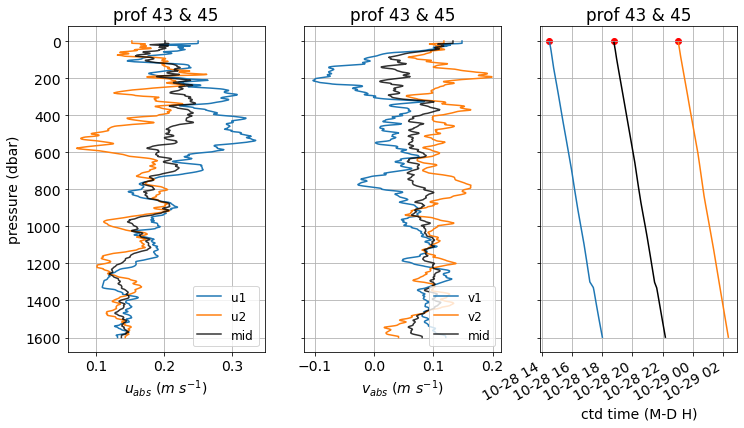

In [36]:
i = 42

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey = True, figsize = (12,6))

u_abs[i].plot(ax = ax1, y = 'pressure')
u_abs[i+2].plot(ax = ax1, y = 'pressure')

ds_no_inertial.u_abs[i].plot(ax = ax1, y = 'pressure', c = 'k', alpha = 0.8)

ax1.legend(['u1', 'u2', 'mid'], loc = 'lower right', fontsize = 12)
ax1.set_title(f'prof {i+1} & {i+2+1}')
ax1.grid()
ax1.invert_yaxis()
ax1.set_xlabel('$u_{abs}$ ($m$ $s^{-1}$)')
ax1.set_ylabel('pressure (dbar)')


v_abs[i].plot(ax = ax2, y = 'pressure')
v_abs[i+2].plot(ax = ax2, y = 'pressure')

ds_no_inertial.v_abs[i].plot(ax = ax2, y = 'pressure', c = 'k', alpha = 0.8)

ax2.legend(['v1', 'v2', 'mid'], loc = 'lower right', fontsize = 12)
ax2.set_title(f'prof {i+1} & {i+2+1}')
ax2.grid()
ax2.set_xlabel('$v_{abs}$ ($m$ $s^{-1}$)')
ax2.set_ylabel('')


float_num.ctd_t[i].plot(ax = ax3, y = 'pressure')
float_num.ctd_t[i+2].plot(ax = ax3, y = 'pressure')

ax3.scatter(float_num.time[[i, i+2]].data, [0, 0], c = 'r')
ax3.scatter(ds_no_inertial.time[i].data, 0, c= 'r')

ds_no_inertial.ctd_t[i].plot(ax = ax3, y = 'pressure', c = 'k')

ax3.set_title(f'prof {i+1} & {i+2+1}')
ax3.grid()
ax3.set_xlabel('ctd time (M-D H)')
ax3.set_ylabel('')

In [181]:
# settings.save_figure(fig, my_path, f'subinertial_{i+1}.png', dpi = 600, pad = 0.2)

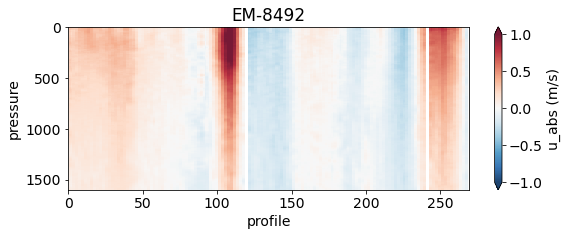

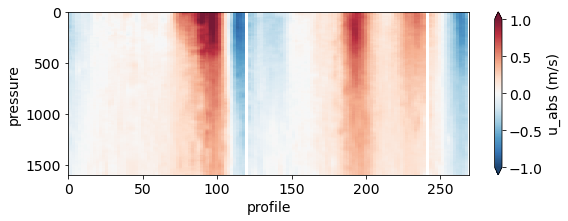

In [56]:
fig, ax = plt.subplots(figsize = (9,3))
ds[8492].u_abs.plot(x = 'profile', extend = 'both', alpha = 0.9, cmap = 'RdBu_r', 
          vmin = -1, vmax = 1, cbar_kwargs = dict(label = 'u_abs (m/s)'))
ax.invert_yaxis()
plt.title('EM-8492')

fig, ax = plt.subplots(figsize = (9,3))
ds[8492].v_abs.plot(x = 'profile', extend = 'both', alpha = 0.9, cmap = 'RdBu_r', 
          vmin = -1, vmax = 1, cbar_kwargs = dict(label = 'u_abs (m/s)'))
ax.invert_yaxis()

Text(0.5, 1.0, 'interpolated back to original times')

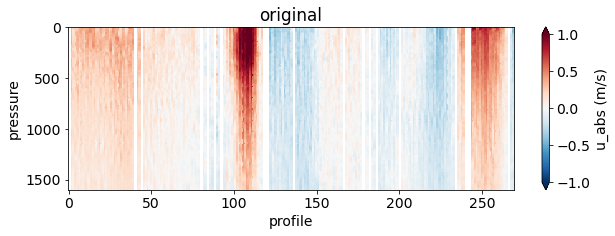

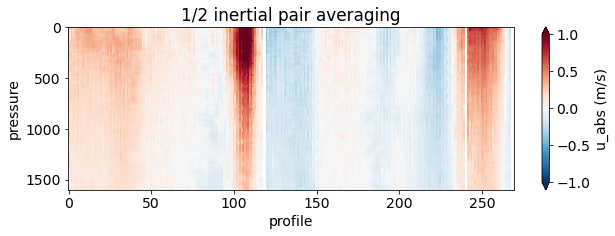

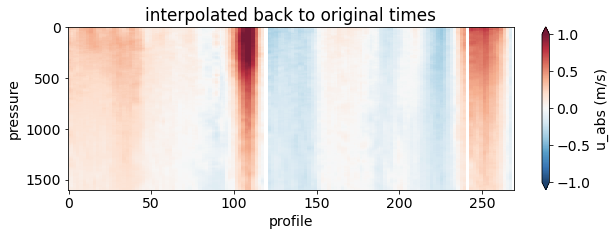

In [75]:
fig, ax = plt.subplots(figsize = (10,3))
im = plt.pcolor(np.arange(0, len(u_abs)), float_num.pressure, u_abs.data.transpose(), vmin = -1, vmax = 1, 
                                                                shading='auto', cmap = 'RdBu_r')
ax.invert_yaxis()
plt.colorbar(im, extend = 'both', label = 'u_abs (m/s)')
plt.ylabel('pressure')
plt.xlabel('profile')
plt.title('original')

fig, ax = plt.subplots(figsize = (10,3))
im = plt.pcolor(np.arange(0, len(ds_no_inertial.u_abs)), ds_no_inertial.pressure, ds_no_inertial.u_abs.data.transpose(), 
                                                    shading='auto', vmin = -1, vmax = 1, cmap = 'RdBu_r')
ax.invert_yaxis()
plt.colorbar(im, extend = 'both', label = 'u_abs (m/s)')
plt.title('1/2 inertial pair averaging')
plt.ylabel('pressure')
plt.xlabel('profile')

fig, ax = plt.subplots(figsize = (10,3))
ds[floatid].u_abs.plot(x = 'profile', extend = 'both', alpha = 0.9, cmap = 'RdBu_r', 
          vmin = -1, vmax = 1, cbar_kwargs = dict(label = 'u_abs (m/s)'))
ax.invert_yaxis()
plt.title('interpolated back to original times')

Text(0.5, 1.0, 'interpolated back to original times')

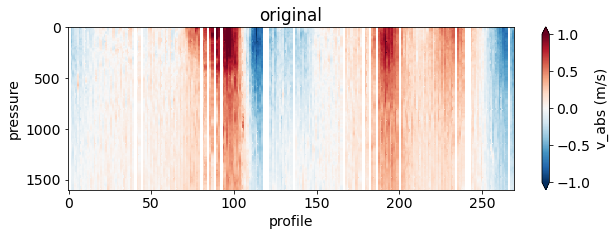

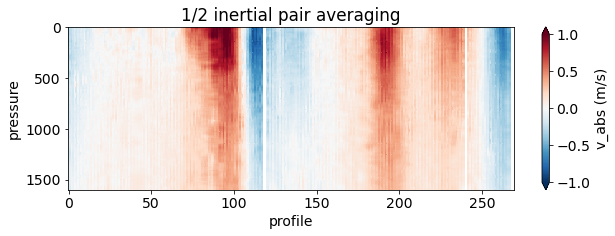

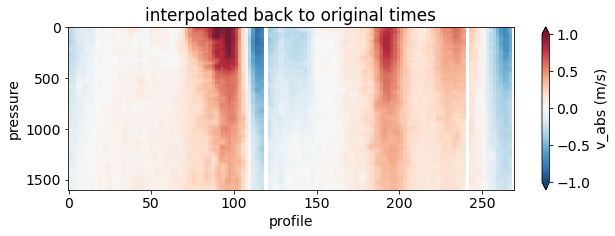

In [76]:
fig, ax = plt.subplots(figsize = (10,3))
im = plt.pcolor(np.arange(0, len(v_abs)), float_num.pressure, v_abs.data.transpose(), vmin = -1, vmax = 1, 
                                            cmap = 'RdBu_r', shading='auto',)
ax.invert_yaxis()
plt.colorbar(im, extend = 'both', label = 'v_abs (m/s)')
plt.ylabel('pressure')
plt.xlabel('profile')
plt.title('original')

fig, ax = plt.subplots(figsize = (10,3))
im = plt.pcolor(np.arange(0, len(ds_no_inertial.v_abs)), ds_no_inertial.pressure, ds_no_inertial.v_abs.data.transpose(), 
                                            shading='auto', vmin = -1, vmax = 1, cmap = 'RdBu_r')
ax.invert_yaxis()
plt.colorbar(im, extend = 'both', label = 'v_abs (m/s)')
plt.title('1/2 inertial pair averaging')
plt.ylabel('pressure')
plt.xlabel('profile')

fig, ax = plt.subplots(figsize = (10,3))
ds[floatid].v_abs.plot(x = 'profile', extend = 'both', alpha = 0.9, cmap = 'RdBu_r', 
          vmin = -1, vmax = 1, cbar_kwargs = dict(label = 'v_abs (m/s)'))
ax.invert_yaxis()
plt.title('interpolated back to original times')

### Concatenated floats

In [77]:
abs_vels = {}
rot_vels = {}
ctd_time = {}

datadir = os.path.join(os.sep, 'Users', 'mijakes', 'checkouts', 'phd', 'data', 'floats')
                       
for floatid in floatids:
    #absolute velocities
    file = os.path.join(datadir, 'absolute_velocity', 'by_profile', 'abs_vel_%s_extra_qc.nc' %floatid)
    abs_vels[floatid] = xr.open_dataset(file)
    
    #rotated velocities
    file = os.path.join(datadir, 'rotated_velocity', 'by_profile', 'rot_vel_%s.nc' %floatid)
    rot_vels[floatid] = xr.open_dataset(file)
    
    # time recorded from float ctd
    file = os.path.join(datadir, 'extra_vars', 'macquarie_ema-%s_qc.nc' %floatid)
    ctd_time[floatid] = xr.open_dataset(file).ctd_t

In [78]:
ds_dist = imports.sub_inertial_ds(ema, floatids, datadir, xdim = 'distance', rot_vels = rot_vels)

In [79]:
u_abs = {}
v_abs = {}
CT, SA = {}, {}
mld = {}

imp.reload(calc)
for floatid in floatids:
    # sub-inertial absolute velocities 
    u_abs[floatid], v_abs[floatid] = ds_dist[floatid].u_abs, ds_dist[floatid].v_abs
    
    # sub-inertial temperature and salinity
    CT[floatid], SA[floatid] = ds_dist[floatid].CT, ds_dist[floatid].SA
    mld[floatid] = calc.MLD_float(ds_dist[floatid], floatid, plot = False)
    
mld_on_p, end_dist, d_rs = ct.concatenated_flts(mld, floatids, new_dim = True)

In [82]:
# potential density
imp.reload(ct)

S_concat, end_dist, d_rs = ct.concatenated_flts(SA, floatids, interp_to_dens = False, new_dim = True)
T_concat, end_dist, d_rs = ct.concatenated_flts(CT, floatids, interp_to_dens = False, new_dim = True)
pdens = calc.potentialDensity(S_concat.pressure, S_concat, T_concat)
levels = np.arange(26.8,27.8,0.1)

In [80]:
u_abs_concat, end_dist, d_rs = ct.concatenated_flts(u_abs, floatids, interp_to_dens = False, new_dim = True)
v_abs_concat, end_dist, d_rs = ct.concatenated_flts(v_abs, floatids, interp_to_dens = False, new_dim = True)
ticks, values, flt_dist_loc = plots.concatTickValues(d_rs)

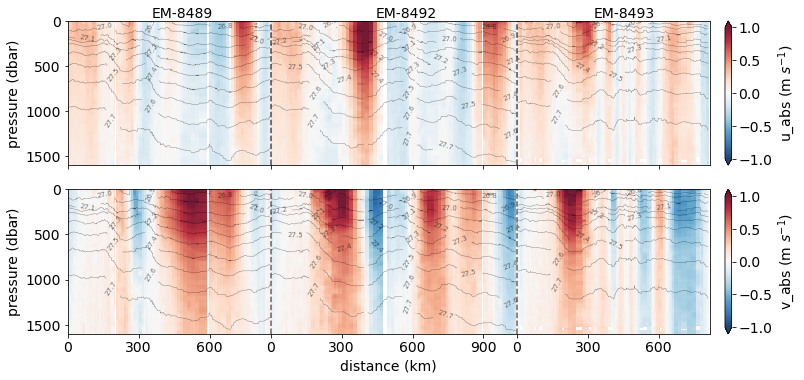

In [83]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex = True, sharey = True, figsize = (12,5.5))

#zonal velocity
im1 = u_abs_concat.plot(ax = ax1, x = 'distance', cmap = 'RdBu_r', vmin = -1, vmax = 1, alpha = 0.9, extend = 'both',
                                            cbar_kwargs={"label": "u_abs (m $s^{-1}$)", 'pad':0.02})

for i in range(0,len(flt_dist_loc)):
    ax1.axvline(x = flt_dist_loc[i], linestyle = '--', color = 'k', alpha = 0.7)
    ax2.axvline(x = flt_dist_loc[i], linestyle = '--', color = 'k', alpha = 0.6)
    
ax1.set_xticks(ticks)
ax1.set_xticklabels(values)

CS = pdens.plot.contour(ax = ax1, x = 'distance', colors = 'k', linewidths = 0.4, linestyles = 'solid', 
                                                                levels = levels, alpha = 0.5)
plt.clabel(CS, inline=True, fontsize=7, fmt = '%1.1f')

#meridional velocity   
im2 = v_abs_concat.plot(ax = ax2, x = 'distance', cmap = 'RdBu_r', vmin = -1, vmax = 1, alpha = 0.9, extend = 'both',
                                            cbar_kwargs={"label": "v_abs (m $s^{-1}$)", 'pad':0.02})

CS = pdens.plot.contour(ax = ax2, x = 'distance', colors = 'k', linewidths = 0.4, linestyles = 'solid', 
                                                                    levels = levels, alpha = 0.5)
plt.clabel(CS, inline=True, fontsize=7, fmt = '%1.1f')

ax1.invert_yaxis()
ax1.set_ylabel('pressure (dbar)')
ax1.set_xlabel('')
ax2.set_ylabel('pressure (dbar)')
ax2.set_xlabel('distance (km)')

ax1.text(0.13, 1.02, 'EM-8489', transform = ax1.transAxes)
ax1.text(0.48, 1.02, 'EM-8492', transform = ax1.transAxes)
ax1.text(0.82, 1.02, 'EM-8493', transform = ax1.transAxes)

plt.tight_layout()
plt.show()